<a href="https://colab.research.google.com/github/sdikici/Demand_Forecasting_Prophet_DeepAR/blob/main/Prophet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d sercandikici/merged-dataset-electricty-weather-for-modelling
! unzip merged-dataset-electricty-weather-for-modelling.zip

Dataset URL: https://www.kaggle.com/datasets/sercandikici/merged-dataset-electricty-weather-for-modelling
License(s): unknown
  0% 0.00/104k [00:00<?, ?B/s]
100% 104k/104k [00:00<00:00, 43.3MB/s]
Archive:  merged-dataset-electricty-weather-for-modelling.zip
  inflating: merged_data.csv         


In [3]:
from prophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def r_squared(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mean_y_true = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y_true) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2


In [5]:
df_merged = pd.read_csv("merged_data.csv")
df_merged['settlement_date'] = pd.to_datetime(df_merged['settlement_date'])
df_merged

,settlement_date,tsd,is_holiday,temp
0,2021-01-01 00:00:00,28552.00,1.0,1.55
1,2021-01-01 02:00:00,26579.75,1.0,1.60
2,2021-01-01 04:00:00,25236.00,1.0,0.55
3,2021-01-01 06:00:00,25792.25,1.0,-0.35
4,2021-01-01 08:00:00,28162.75,1.0,-0.10
...,...,...,...,...
13136,2023-12-31 16:00:00,34006.00,0.0,7.60
13137,2023-12-31 18:00:00,32273.00,0.0,8.20
13138,2023-12-31 20:00:00,27456.50,0.0,8.45
13139,2023-12-31 22:00:00,24139.25,0.0,8.35


Model 1 predict 7 days in the future

In [6]:
df_model_1 = df_merged[["tsd","settlement_date"]]
df_model_1.columns=["y","ds"]
df_model_1

,y,ds
0,28552.00,2021-01-01 00:00:00
1,26579.75,2021-01-01 02:00:00
2,25236.00,2021-01-01 04:00:00
3,25792.25,2021-01-01 06:00:00
4,28162.75,2021-01-01 08:00:00
...,...,...
13136,34006.00,2023-12-31 16:00:00
13137,32273.00,2023-12-31 18:00:00
13138,27456.50,2023-12-31 20:00:00
13139,24139.25,2023-12-31 22:00:00


train test split

In [7]:
split_from = 90*12 #train test split is from 90days

train_data = df_model_1[:-split_from]
test_data = df_model_1[-split_from:]
print(train_data.shape)
print(test_data.shape)

(12061, 2)
(1080, 2)


In [8]:
test_data

,y,ds
12061,21072.25,2023-10-03 02:00:00
12062,21265.25,2023-10-03 04:00:00
12063,25727.25,2023-10-03 06:00:00
12064,28366.25,2023-10-03 08:00:00
12065,26361.75,2023-10-03 10:00:00
...,...,...
13136,34006.00,2023-12-31 16:00:00
13137,32273.00,2023-12-31 18:00:00
13138,27456.50,2023-12-31 20:00:00
13139,24139.25,2023-12-31 22:00:00


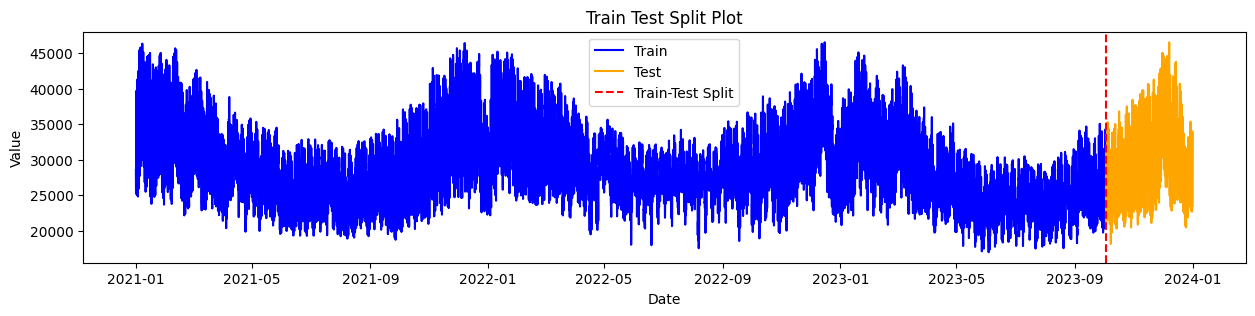

In [9]:
plt.figure(figsize=(15,3))
plt.plot(train_data["ds"],train_data["y"],color="blue", label="Train")
plt.plot(test_data["ds"],test_data["y"], color="orange", label="Test")
plt.axvline(test_data.iloc[0]['ds'], color="red", linestyle="--", label="Train-Test Split")

plt.title('Train Test Split Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

train parameters

In [10]:
freq = "2H"
seasonality_prior_scale = 0.01
changepoint_prior_scale = 0.05
days_to_predict=30
periods = days_to_predict*12
mcmc_samples = 50

Train the model

In [11]:
m = Prophet(mcmc_samples=mcmc_samples, changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale)
m.fit(train_data)
future_1 = m.make_future_dataframe(periods=periods , freq=freq)
forecast_1 = m.predict(future_1)

DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl03eus0x/t3418h4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl03eus0x/muyzhx_r.json
16:24:28 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=12349', 'data', 'file=/tmp/tmpl03eus0x/t3418h4k.json', 'init=/tmp/tmpl03eus0x/muyzhx_r.json', 'output', 'file=/tmp/tmpl03eus0x/prophet_modeludolypzd/prophet_model-20240510162428_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=12349', 'data', 'file=/tmp/tmpl03eus0x/t3418h4k.json', 'init=/tmp/tmpl03eus0x/muyzhx_r.json', 'output', 'file=/tmp/tmpl03eus0x/prophet_modeludolypzd/prophet_model-20240510162428_2.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

16:27:32 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=12349', 'data', 'file=/tmp/tmpl03eus0x/t3418h4k.json', 'init=/tmp/tmpl03eus0x/muyzhx_r.json', 'output', 'file=/tmp/tmpl03eus0x/prophet_modeludolypzd/prophet_model-20240510162428_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpl03eus0x/prophet_modeludolypzd/prophet_model-20240510162428_1.csv
 console_msgs (if any):
	/tmp/tmpl03eus0x/prophet_modeludolypzd/prophet_model-20240510162428_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 25
    num_warmup = 25
    save_warmup = 0 (Default)
    thin = 1 (Default)


In [12]:
#create forecasts
forecast_1 = m.predict(future_1)
forecast_1.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
12416,2023-11-01 16:00:00,26801.880754,27386.221170,37740.286536,26490.912480,27129.857311,5988.167227,5563.548613,6535.125373,3794.740194,...,1318.119882,1179.371737,1431.248572,875.307151,453.644214,1359.024956,0.0,0.0,0.0,32790.047981
12417,2023-11-01 18:00:00,26801.272953,29768.128851,39265.644198,26490.211884,27129.996788,7600.295076,7083.765917,8163.613212,5396.866031,...,1321.405696,1199.900049,1427.031869,882.023350,459.532766,1366.610928,0.0,0.0,0.0,34401.568029
12418,2023-11-01 20:00:00,26800.665151,26613.345451,36101.893625,26489.511288,27130.136266,4831.168486,4374.657664,5325.820439,2621.353031,...,1321.071965,1219.791879,1416.328704,888.743490,465.436138,1374.181332,0.0,0.0,0.0,31631.833638
12419,2023-11-01 22:00:00,26800.057350,21807.295338,31661.311436,26488.810692,27130.275743,323.891134,-84.028970,749.195865,-1888.745611,...,1317.168697,1226.262141,1404.799217,895.468048,471.354881,1381.736530,0.0,0.0,0.0,27123.948484
12420,2023-11-02 00:00:00,26799.449549,20007.492052,29823.411476,26488.110096,27130.415221,-1952.049168,-2392.174705,-1491.253798,-4164.206000,...,1309.959327,1220.591072,1381.352032,902.197505,477.289557,1389.276893,0.0,0.0,0.0,24847.400381


In [13]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast_1)


In [14]:
forecast_days = forecast_1[forecast_1["ds"] >= test_data["ds"].iloc[0]]
test_days = test_data[(test_data["ds"] >= test_data["ds"].iloc[0])&(test_data["ds"] <= forecast_days["ds"].iloc[-1])]

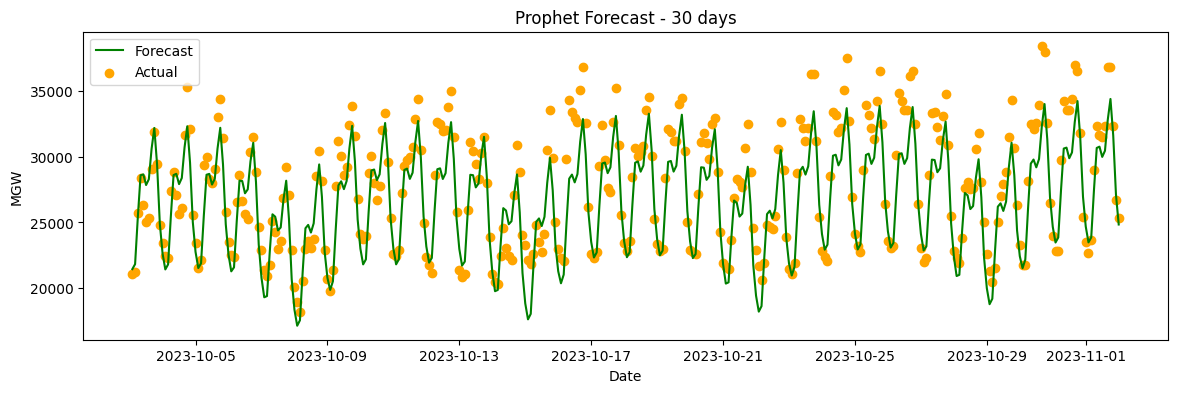

In [15]:
def forecast_plot(forecast_days,test_days, days):

  fig, ax = plt.subplots(figsize=(14, 4))
  ax.plot(forecast_days['ds'], forecast_days['yhat'], label='Forecast', color='green')
  ax.scatter(test_days['ds'], test_days['y'], label='Actual', color='orange')
  ax.set_xlabel('Date')
  ax.set_ylabel('MGW')
  plt.title(f'Prophet Forecast - {days} days')
  plt.legend()
  plt.show()

forecast_plot(forecast_days,test_days,days_to_predict)

In [16]:
mape_1 = mean_absolute_percentage_error(test_days["y"],forecast_days["yhat"])
rmse_1 = root_mean_squared_error(test_days["y"],forecast_days["yhat"])
rsqr_1 = r_squared(test_days["y"],forecast_days["yhat"])
print(f"MAPE without regressors: {round(mape_1,7)}")
print(f"RMSE without regressors: {round(rmse_1,7)}")
print(f"R-squared without regressors: {round(rsqr_1,7)}")

MAPE without regressors: 0.0567267
RMSE without regressors: 2037.0430587
R-squared without regressors: 0.8039107


training model_2, additional holidays

In [17]:
m2 = Prophet(mcmc_samples=mcmc_samples, changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale)
m2.add_country_holidays(country_name="UK")
m2.fit(train_data)

future_2 = m2.make_future_dataframe(periods=periods , freq=freq)
forecast2 = m2.predict(future_2)
forecast2

DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl03eus0x/ro0eg95f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl03eus0x/lso996f4.json
16:27:46 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=61784', 'data', 'file=/tmp/tmpl03eus0x/ro0eg95f.json', 'init=/tmp/tmpl03eus0x/lso996f4.json', 'output', 'file=/tmp/tmpl03eus0x/prophet_modelzen_hxhp/prophet_model-20240510162746_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=61784', 'data', 'file=/tmp/tmpl03eus0x/ro0eg95f.json', 'init=/tmp/tmpl03eus0x/lso996f4.json', 'output', 'file=/tmp/tmpl03eus0x/prophet_modelzen_hxhp/prophet_model-20240510162746_2.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

16:27:58 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=61784', 'data', 'file=/tmp/tmpl03eus0x/ro0eg95f.json', 'init=/tmp/tmpl03eus0x/lso996f4.json', 'output', 'file=/tmp/tmpl03eus0x/prophet_modelzen_hxhp/prophet_model-20240510162746_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpl03eus0x/prophet_modelzen_hxhp/prophet_model-20240510162746_1.csv
 console_msgs (if any):
	/tmp/tmpl03eus0x/prophet_modelzen_hxhp/prophet_model-20240510162746_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 25
    num_warmup = 25
    save_warmup = 0 (Default)
    thin = 1 (Default)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Boxing Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01 00:00:00,30366.218022,22632.314954,33944.066758,30198.984769,30599.459710,0.0,0.0,0.0,0.0,...,1035.292189,875.733139,1190.621675,1410.035375,1211.165515,1622.379827,0.0,0.0,0.0,28120.826720
1,2021-01-01 02:00:00,30365.720832,20933.185419,32458.214770,30198.459485,30598.888924,0.0,0.0,0.0,0.0,...,985.707601,837.732651,1136.435066,1417.118836,1216.128172,1629.318329,0.0,0.0,0.0,26951.892602
2,2021-01-01 04:00:00,30365.223641,21413.476621,32860.454896,30197.934201,30598.318137,0.0,0.0,0.0,0.0,...,924.238858,774.070457,1063.634476,1424.523250,1221.442929,1636.554448,0.0,0.0,0.0,27247.931561
3,2021-01-01 06:00:00,30364.726451,25213.401112,36039.020442,30197.408917,30597.747351,0.0,0.0,0.0,0.0,...,848.367276,697.568215,980.905657,1432.247560,1227.108933,1644.087111,0.0,0.0,0.0,30758.572350
4,2021-01-01 08:00:00,30364.229261,28142.971578,39190.274934,30196.883633,30597.176565,0.0,0.0,0.0,0.0,...,755.674045,605.777641,874.091678,1440.290665,1233.125286,1651.915207,0.0,0.0,0.0,33869.678470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12416,2023-11-01 16:00:00,26816.379059,26623.482023,37542.991705,26474.842784,27185.427321,0.0,0.0,0.0,0.0,...,1323.953495,1183.710746,1444.626071,659.358088,391.758728,853.729343,0.0,0.0,0.0,32589.134328
12417,2023-11-01 18:00:00,26815.797241,28797.504631,39736.447149,26474.116368,27184.980520,0.0,0.0,0.0,0.0,...,1327.480464,1193.018196,1464.549063,665.459430,398.431270,860.556742,0.0,0.0,0.0,34215.409740
12418,2023-11-01 20:00:00,26815.215422,25799.086892,36807.941494,26473.389952,27184.533719,0.0,0.0,0.0,0.0,...,1326.477463,1200.467489,1472.732025,671.567409,405.120220,867.383288,0.0,0.0,0.0,31467.311810
12419,2023-11-01 22:00:00,26814.633604,21265.717399,31815.852607,26472.663536,27184.086918,0.0,0.0,0.0,0.0,...,1321.062265,1198.048253,1453.351574,677.682555,411.825885,874.209372,0.0,0.0,0.0,26879.921476


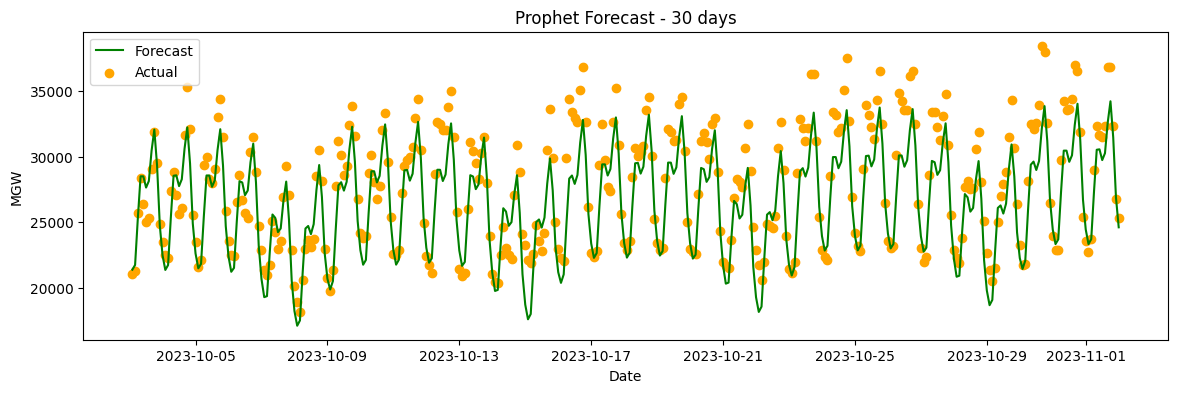

In [18]:
forecast2__days = forecast2[forecast2 ["ds"] >= test_data["ds"].iloc[0]]
forecast_plot(forecast2__days,test_days,days_to_predict)

In [19]:
mape_2 = mean_absolute_percentage_error(test_days["y"],forecast2__days["yhat"])
rmse_2 = root_mean_squared_error(test_days["y"],forecast2__days["yhat"])
rsqr_2 = r_squared(test_days["y"],forecast2__days["yhat"])
print(f"MAPE holidays added: {round(mape_2,7)}")
print(f"RMSE holidays added: {round(rmse_2,7)}")
print(f"R-squared holidays added: {round(rsqr_2,7)}")

MAPE holidays added: 0.0584509
RMSE holidays added: 2110.8031869
R-squared holidays added: 0.789453


model 3 holiday+weather data

In [20]:
df_model_3 = df_merged[["tsd","settlement_date","temp"]]
df_model_3.columns=["y","ds","temp"]
df_model_3

,y,ds,temp
0,28552.00,2021-01-01 00:00:00,1.55
1,26579.75,2021-01-01 02:00:00,1.60
2,25236.00,2021-01-01 04:00:00,0.55
3,25792.25,2021-01-01 06:00:00,-0.35
4,28162.75,2021-01-01 08:00:00,-0.10
...,...,...,...
13136,34006.00,2023-12-31 16:00:00,7.60
13137,32273.00,2023-12-31 18:00:00,8.20
13138,27456.50,2023-12-31 20:00:00,8.45
13139,24139.25,2023-12-31 22:00:00,8.35


In [21]:
train_data_3 = df_model_3[:-split_from]
test_data_3 = df_model_3[-split_from:]

In [22]:
m3= Prophet(mcmc_samples=mcmc_samples, changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale)
m3.add_country_holidays(country_name="UK")
m3.add_regressor("temp", mode="additive")
m3.fit(train_data_3)
future3 = m3.make_future_dataframe(periods=periods, freq=freq)

DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl03eus0x/07vbp9b5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl03eus0x/8d7srrew.json
16:28:06 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=44747', 'data', 'file=/tmp/tmpl03eus0x/07vbp9b5.json', 'init=/tmp/tmpl03eus0x/8d7srrew.json', 'output', 'file=/tmp/tmpl03eus0x/prophet_model29h94732/prophet_model-20240510162807_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=44747', 'data', 'file=/tmp/tmpl03eus0x/07vbp9b5.json', 'init=/tmp/tmpl03eus0x/8d7srrew.json', 'output', 'file=/tmp/tmpl03eus0x/prophet_model29h94732/prophet_model-20240510162807_2.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

16:28:21 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=44747', 'data', 'file=/tmp/tmpl03eus0x/07vbp9b5.json', 'init=/tmp/tmpl03eus0x/8d7srrew.json', 'output', 'file=/tmp/tmpl03eus0x/prophet_model29h94732/prophet_model-20240510162807_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpl03eus0x/prophet_model29h94732/prophet_model-20240510162807_1.csv
 console_msgs (if any):
	/tmp/tmpl03eus0x/prophet_model29h94732/prophet_model-20240510162807_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 25
    num_warmup = 25
    save_warmup = 0 (Default)
    thin = 1 (Default)


In [23]:
#create train and text idx which will be used to index future dataframe
train_idx = future3["ds"].isin(train_data_3.ds)
test_idx = ~train_idx
#add regressors to future dataframe
reg = ["temp"]
for r in reg:
  future3.loc[train_idx, r] = train_data_3[r].to_list()
for r in reg:
  future3.loc[test_idx, r] = test_data_3.iloc[:periods][r].to_list()
future3

,ds,temp
0,2021-01-01 00:00:00,1.55
1,2021-01-01 02:00:00,1.60
2,2021-01-01 04:00:00,0.55
3,2021-01-01 06:00:00,-0.35
4,2021-01-01 08:00:00,-0.10
...,...,...
12416,2023-11-01 16:00:00,12.45
12417,2023-11-01 18:00:00,10.55
12418,2023-11-01 20:00:00,10.10
12419,2023-11-01 22:00:00,9.95


In [24]:
forecast3 = m3.predict(future3)
forecast3

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Boxing Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01 00:00:00,29844.740027,25087.045128,34081.090532,29721.063108,29978.424515,0.0,0.0,0.0,0.0,...,1065.281305,993.111157,1149.572528,314.457695,56.481433,631.841166,0.0,0.0,0.0,29587.714331
1,2021-01-01 02:00:00,29844.231125,23154.552225,32867.681926,29720.555918,29977.908608,0.0,0.0,0.0,0.0,...,1015.877565,952.820212,1098.276952,318.916923,63.030525,636.236052,0.0,0.0,0.0,28199.515665
2,2021-01-01 04:00:00,29843.722224,24081.916868,32910.311532,29720.048728,29977.392701,0.0,0.0,0.0,0.0,...,953.672896,882.674462,1037.767598,323.625375,69.865046,640.876196,0.0,0.0,0.0,28659.388420
3,2021-01-01 06:00:00,29843.213322,27988.048508,36733.711992,29719.541538,29976.876793,0.0,0.0,0.0,0.0,...,876.145780,803.527799,954.389850,328.582333,76.983967,645.760978,0.0,0.0,0.0,32478.450311
4,2021-01-01 08:00:00,29842.704420,31244.372860,40151.802401,29719.034348,29976.360886,0.0,0.0,0.0,0.0,...,780.917386,722.448025,863.600696,333.787044,84.386218,650.889741,0.0,0.0,0.0,35863.624413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12416,2023-11-01 16:00:00,26591.681428,28809.734584,37252.269075,26328.176639,26787.956426,0.0,0.0,0.0,0.0,...,1344.350412,1237.571130,1468.218673,682.390323,541.226277,857.071993,0.0,0.0,0.0,33253.322616
12417,2023-11-01 18:00:00,26591.000509,30362.644629,39687.279505,26327.400057,26787.365828,0.0,0.0,0.0,0.0,...,1342.702174,1252.831444,1464.713626,687.205961,546.705763,862.213221,0.0,0.0,0.0,35164.074147
12418,2023-11-01 20:00:00,26590.319591,27786.712866,36500.411341,26326.623474,26786.775231,0.0,0.0,0.0,0.0,...,1337.551035,1250.201208,1452.467490,692.013022,552.161945,867.327771,0.0,0.0,0.0,32148.588917
12419,2023-11-01 22:00:00,26589.638673,23019.100803,31450.891932,26325.846892,26786.184634,0.0,0.0,0.0,0.0,...,1329.111310,1248.333148,1434.127069,696.811777,557.614964,872.415791,0.0,0.0,0.0,27260.986060


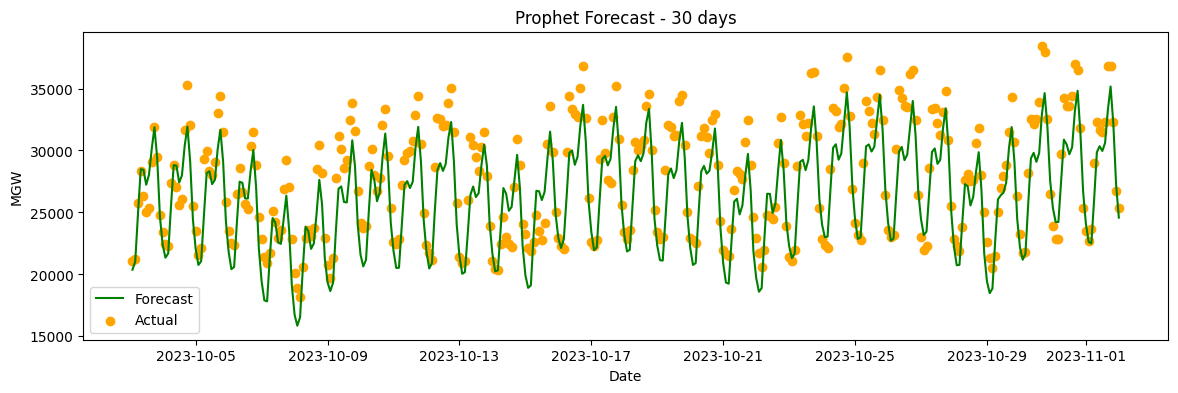

In [25]:
forecast3_days = forecast3[forecast3["ds"] >= test_data_3["ds"].iloc[0]]
test3_days = test_data_3[(test_data_3["ds"] >= test_data_3["ds"].iloc[0])&(test_data_3["ds"] <= forecast3_days["ds"].iloc[-1])]
forecast_plot(forecast3_days,test3_days,days_to_predict)

In [26]:
mape_3 = mean_absolute_percentage_error(test3_days["y"],forecast3_days["yhat"])
rmse_3 = root_mean_squared_error(test3_days["y"],forecast3_days["yhat"])
rsqr_3 = r_squared(test3_days["y"],forecast3_days["yhat"])
print(f"MAPE holidays+weather added: {round(mape_3,7)}")
print(f"RMSE holidays+weather added: {round(rmse_3,7)}")
print(f"R-squared holidays+weather added: {round(rsqr_3,7)}")

MAPE holidays+weather added: 0.0662124
RMSE holidays+weather added: 2231.692641
R-squared holidays+weather added: 0.7646456


In [27]:
from prophet.utilities import regressor_coefficients
coefficients = regressor_coefficients(m3)

print(coefficients)

  regressor regressor_mode     center  coef_lower        coef  coef_upper
0      temp       additive  12.632974  -303.39436 -291.298485 -278.240584


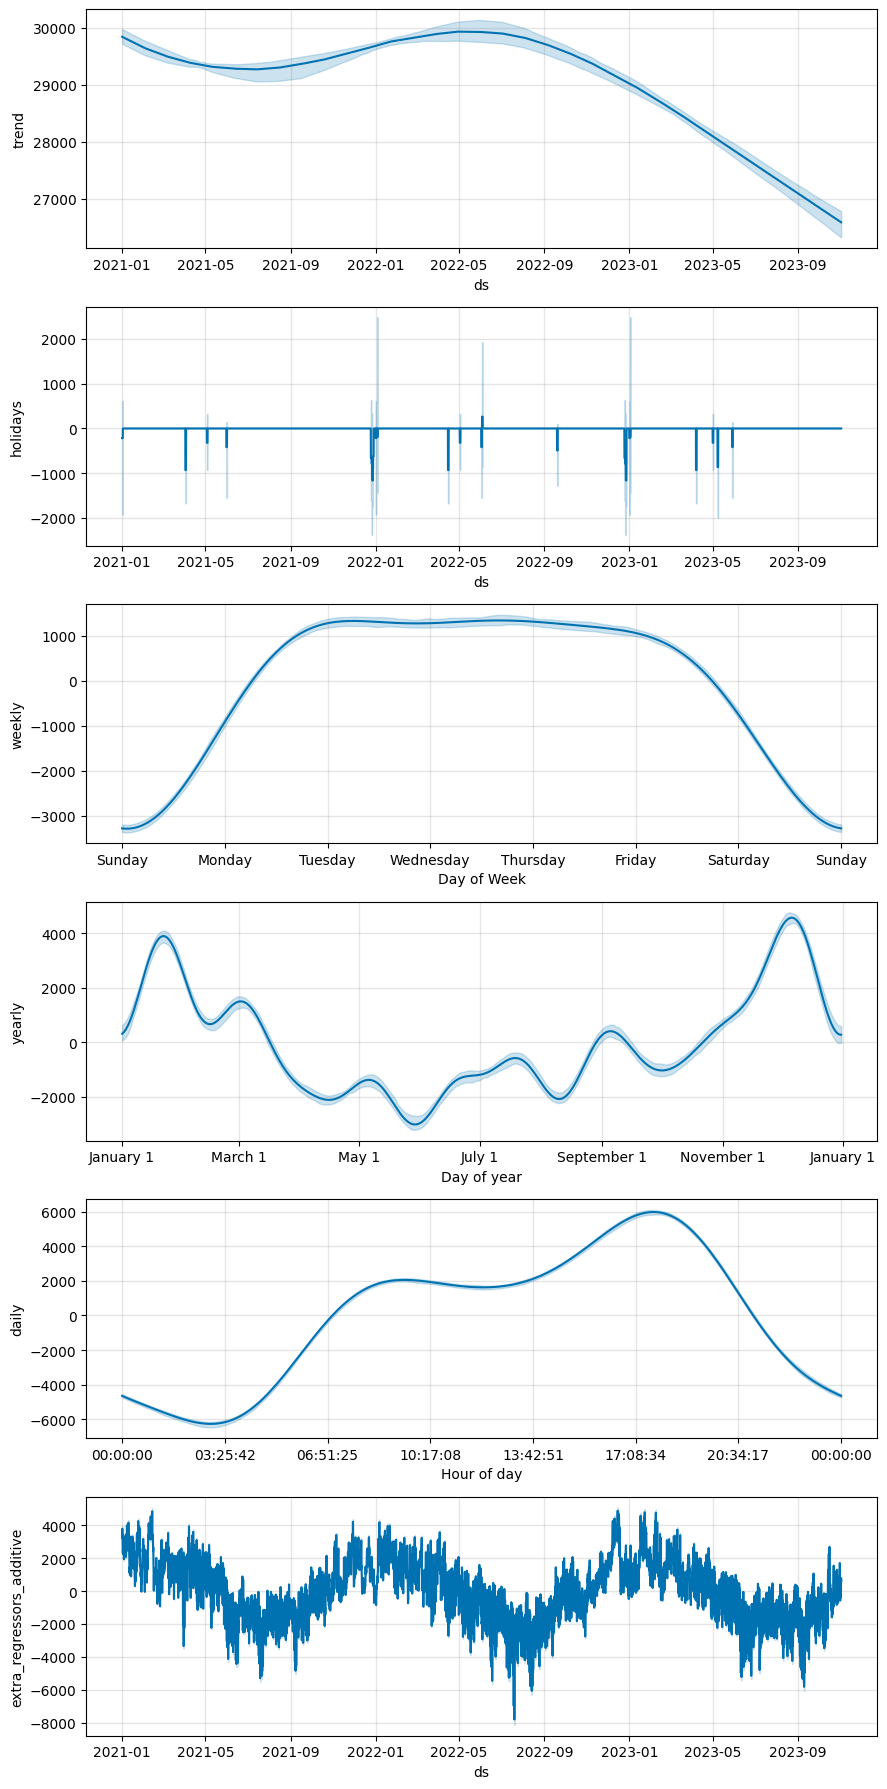

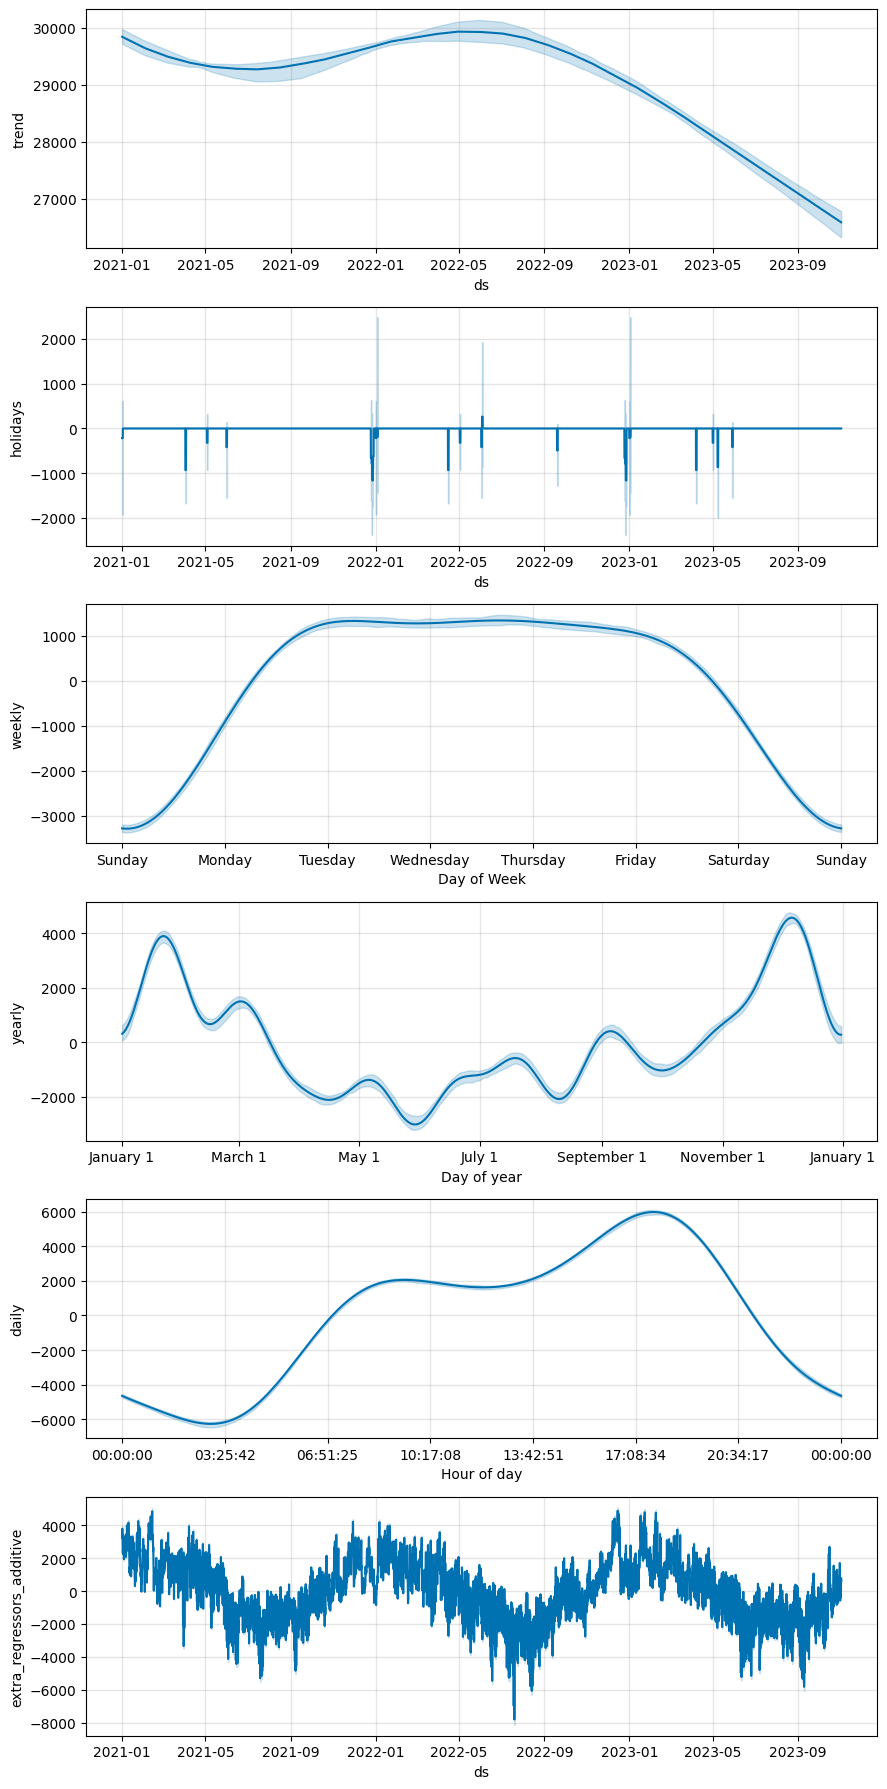

In [28]:
m3.plot_components(forecast3)